In [1]:
# ----------------------------------------------------------------- #
#                              MODULES                              #

# Standard Modules
import os
import glob
import pandas as pd
import numpy as np
from typing import Literal

# Third-Party Modules
import h3
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import h3
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import confusion_matrix
from shapely.geometry import Polygon
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns

#                                                                   #
# ----------------------------------------------------------------- #

# ----------------------------------------------------------------- #
#                             FUNCTIONS                             #

##############
# COLLECTION


# Loan and Process Sightings
def load_and_process_sighting_data(
    directory: str,
    date_col: str,
    lat_col: str,
    lon_col: str,
    id_col: str,
    h3_resolution: int,
    start_date: str = None,
    source: Literal["TMW", "ACARTIA"] = "TMW",
) -> pd.DataFrame:
    """
    Load and process sighting data for TMW or Acartia.

    Args:
        directory (str): Path to CSV files.
        date_col (str): Column name containing datetime string.
        lat_col (str): Latitude column name.
        lon_col (str): Longitude column name.
        id_col (str): Unique identifier or countable column.
        h3_resolution (int): H3 resolution to use.
        start_date (str, optional): Filter records to start at this date.
        source (str): "TMW" or "ACARTIA", for minor formatting differences.

    Returns:
        pd.DataFrame: Aggregated sightings data with full date-grid coverage.
    """
    # Read & concat all CSVs
    data = pd.concat([pd.read_csv(path) for path in glob.glob(f"{directory}/*.csv")])
    data.columns = data.columns.str.upper()

    # Parse date and geo
    data["DATE"] = data[date_col].str[:10]
    data["LATITUDE"] = pd.to_numeric(data[lat_col], errors="coerce")
    data["LONGITUDE"] = pd.to_numeric(data[lon_col], errors="coerce")
    data = data.dropna(subset=["LATITUDE", "LONGITUDE"])

    # Calculate H3 grid
    h3_col = f"H3_GRID_{h3_resolution}"
    data[h3_col] = data.apply(
        lambda x: h3.latlng_to_cell(x["LATITUDE"], x["LONGITUDE"], h3_resolution),
        axis=1,
    )

    data["DATE"] = pd.to_datetime(data["DATE"])
    if start_date:
        data = data[data["DATE"] >= pd.to_datetime(start_date)]

    # Aggregate sightings
    data_agg = data.groupby(["DATE", h3_col], as_index=False).agg(
        SIGHTING_COUNT=(id_col, "count")
    )

    # Build full date-grid frame
    all_dates = pd.date_range(data["DATE"].min(), data["DATE"].max())
    all_grids = data[h3_col].unique()
    full_index = pd.MultiIndex.from_product(
        [all_dates, all_grids], names=["DATE", h3_col]
    )
    full_df = pd.DataFrame(index=full_index).reset_index()
    full_df["DATE"] = pd.to_datetime(full_df["DATE"])

    # Merge to ensure all date/grid combos exist
    full_data = pd.merge(full_df, data_agg, on=["DATE", h3_col], how="left")
    full_data["SIGHTING_COUNT"] = full_data["SIGHTING_COUNT"].fillna(0)

    return full_data


# H3 to Polygon Extent
def h3_to_polygon(h3_index):
    latlon = h3.cell_to_boundary(h3_index)
    return Polygon([(lon, lat) for lat, lon in latlon])  # Note lon/lat flip


# Clip Sightings to Geometry
def clip_sightings_to_geometry(
    sightings_df, h3_resolution, geometry_gdf, geometry_col="geometry"
):
    """
    Clips a sightings dataframe to a geometry (e.g., marine area) based on H3 grid resolution.

    Parameters:
    - sightings_df (pd.DataFrame): Your sightings data with H3 columns like 'H3_GRID_7'.
    - h3_resolution (int): H3 resolution to use for clipping (e.g., 7).
    - geometry_gdf (gpd.GeoDataFrame): GeoDataFrame containing geometry to clip against.
    - geometry_col (str): The name of the geometry column in geometry_gdf (default: 'geometry').

    Returns:
    - pd.DataFrame: The clipped sightings dataframe.
    """
    h3_col = f"H3_GRID_{h3_resolution}"
    tmp_df = sightings_df[[h3_col]].drop_duplicates().copy()
    tmp_df["geometry"] = tmp_df[h3_col].apply(h3_to_polygon)
    tmp_df = gpd.GeoDataFrame(tmp_df, geometry="geometry", crs="EPSG:4326")

    # Clip to the first polygon (or adjust to match your context)
    tmp_df = tmp_df.clip(geometry_gdf[geometry_col].iloc[0])

    # Merge to keep only the sightings within the clipped geometry
    clipped_sightings = pd.merge(sightings_df, tmp_df, on=h3_col)

    return clipped_sightings


#                                                                   #
# ----------------------------------------------------------------- #

***

## 1. Data Ingest + H3 Encoding

### 1a. Load raw sightings data

#### Data coming from TWM
Preprocessing Steps:
- Date Conversion
- Filter to Date Range
- Species Normalization
- H3 Encoding
- Aggregate Sightings by Date, H3 Grid

#### Data coming from Acartia
Preprocessing Steps:
- Date Conversion
- Filter to Date Range
- Species Normalization
- Filter to Orca Sightings
- H3 Encoding
- Aggregate Sightings by Date, H3 Grid

### 0. Parameters

In [2]:
# Parameters
## H3 Grid Resolution for Modeling
h3_resolution = 5

## TMW Data Path
tmw_directory = "/Users/tylerstevenson/Documents/CODE/orcasalmon/data/twm"

## Acartia Data Path
acartia_directory = (
    "/Users/tylerstevenson/Documents/CODE/FindMyWhale/data/raw/sightings"
)

## Marine Area Geometries
marine_geometries_path = "/Users/tylerstevenson/Documents/CODE/FindMyWhale/data/processed/GIS/POLYGONS/SSEA_REGION_5.parquet"

### 1. Data Ingest

In [3]:
# Data Ingest
## Open Marine Geometries
marine_area = gpd.read_parquet(marine_geometries_path)
marine_area = marine_area.dissolve()

## Open TMW
tmw_data_cleaned = load_and_process_sighting_data(
    directory=tmw_directory,
    date_col="SIGHTDATE",
    lat_col="LATITUDE",
    lon_col="LONGITUDE",
    id_col="DATE",  # or other proxy for sightings count
    h3_resolution=h3_resolution,
    source="TMW",
)

## Open Acartia
acartia_data_cleaned = load_and_process_sighting_data(
    directory=acartia_directory,
    date_col="CREATED",
    lat_col="LATITUDE",
    lon_col="LONGITUDE",
    id_col="ENTRY_ID",
    h3_resolution=h3_resolution,
    start_date="2022-01-01",
    source="ACARTIA",
)

# Conbine Sightings Data
sightings_data = pd.concat([acartia_data_cleaned, tmw_data_cleaned])

## Clip to Marine Area
sightings_data = clip_sightings_to_geometry(
    sightings_data, h3_resolution=h3_resolution, geometry_gdf=marine_area
)

### Exploratory Analysis

In [4]:
# We will look at a couple grids to better inform our modeling decisions for just sightings data

In [5]:
avg_daily_sightings = sightings_data.groupby(
    f"H3_GRID_{h3_resolution}", as_index=False
)["SIGHTING_COUNT"].mean()

In [7]:
# fig = px.histogram(avg_daily_sightings['SIGHTING_COUNT'])
# fig.show()

In [ ]:
# Select a Grid to Investigate
select_typical_sighting = avg_daily_sightings[
    avg_daily_sightings.SIGHTING_COUNT >= avg_daily_sightings.SIGHTING_COUNT.mean()
].iloc[3][f"H3_GRID_{h3_resolution}"]

print("Selected Grid:", select_typical_sighting)

typical_sighting = sightings_data[
    sightings_data[f"H3_GRID_{h3_resolution}"] == select_typical_sighting
].copy()

Selected Grid: 8528d103fffffff


In [10]:
# tmp = typical_sighting[0:1]
# tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs="EPSG:4326")

# tmp.explore()

In [11]:
# fig = px.line(typical_sighting, x="DATE", y="SIGHTING_COUNT")
# fig.show()

In [ ]:
# What About It's Neighbors - What Can They Tell Us?
neighbor_cells_1 = h3.grid_ring(select_typical_sighting, 1)
neighbor_cells_2 = h3.grid_ring(select_typical_sighting, 2)

neighbor_sighting_1 = sightings_data[
    sightings_data[f"H3_GRID_{h3_resolution}"].isin(neighbor_cells_1)
]
mean_neighbor_sighting_1 = neighbor_sighting_1.groupby(["DATE"], as_index=False)[
    "SIGHTING_COUNT"
].mean()

neighbor_sighting_2 = sightings_data[
    sightings_data[f"H3_GRID_{h3_resolution}"].isin(neighbor_cells_2)
]
mean_neighbor_sighting_2 = neighbor_sighting_2.groupby(["DATE"], as_index=False)[
    "SIGHTING_COUNT"
].mean()

In [16]:
fig = px.line()
fig.add_scatter(
    x=typical_sighting["DATE"],
    y=typical_sighting["SIGHTING_COUNT"],
    name="grid_sighting",
)
fig.add_scatter(
    x=mean_neighbor_sighting_1["DATE"],
    y=mean_neighbor_sighting_1["SIGHTING_COUNT"],
    name="neighbor_1_sighting",
)
fig.add_scatter(
    x=mean_neighbor_sighting_2["DATE"],
    y=mean_neighbor_sighting_2["SIGHTING_COUNT"],
    name="neighbor_1_sighting",
)
fig.show()

##### Check Seasonality / Trend

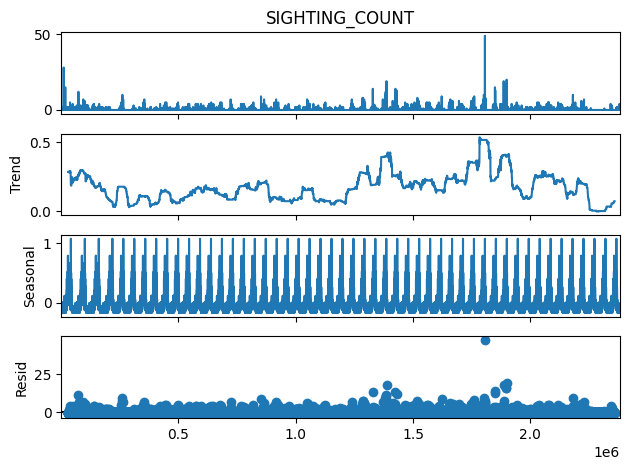

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# typical_sighting

result = seasonal_decompose(
    typical_sighting["SIGHTING_COUNT"], model="additive", period=365
)  # 52 for weekly seasonality

# Plot it
result.plot()
plt.tight_layout()
plt.show()

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the series
result = seasonal_decompose(
    typical_sighting["SIGHTING_COUNT"], model="additive", period=365
)

# Extract residuals
residuals = result.resid

In [23]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

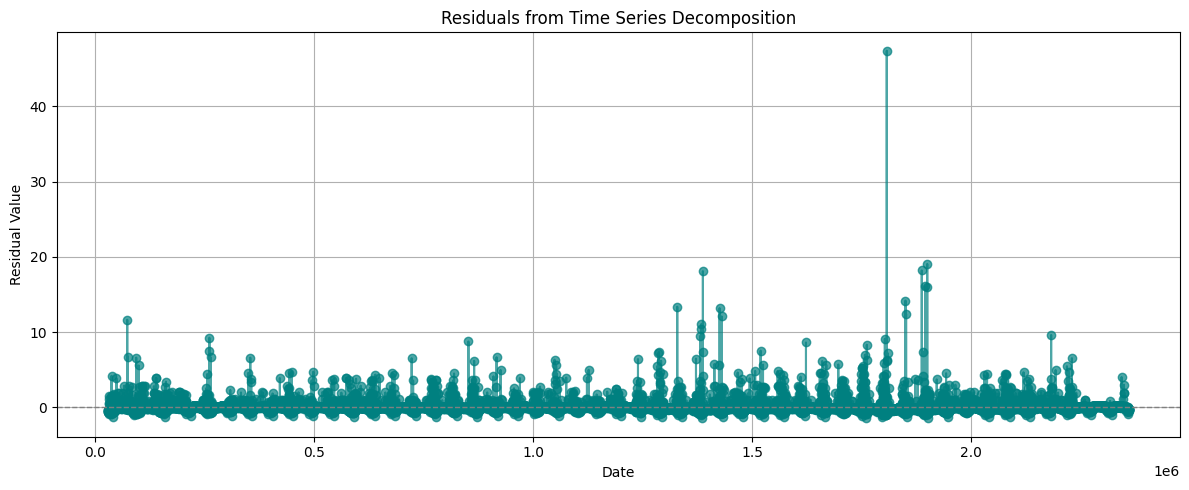

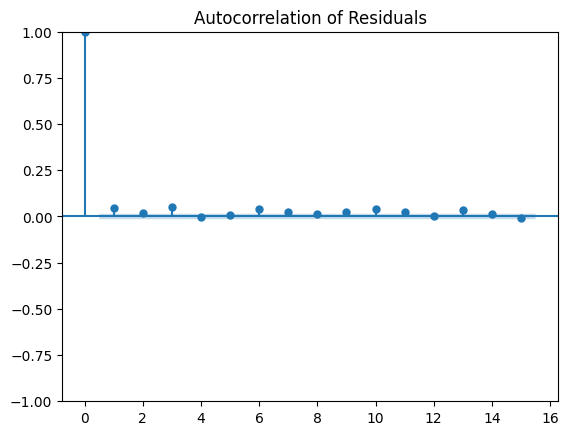

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(residuals, marker="o", linestyle="-", color="teal", alpha=0.7)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Residuals from Time Series Decomposition")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.grid(True)
plt.tight_layout()
plt.show()

plot_acf(residuals.dropna(), lags=15)
plt.title("Autocorrelation of Residuals")
plt.show()

<Axes: xlabel='day_of_week'>

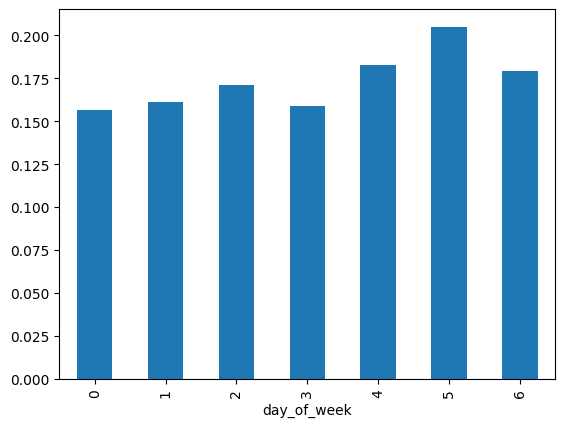

In [31]:
# We will need to handle weekly seasonality... likely due to observer bias

typical_sighting["day_of_week"] = typical_sighting["DATE"].dt.dayofweek
typical_sighting.groupby("day_of_week")["SIGHTING_COUNT"].mean().plot(kind="bar")

<Axes: xlabel='y(t)', ylabel='y(t + 4)'>

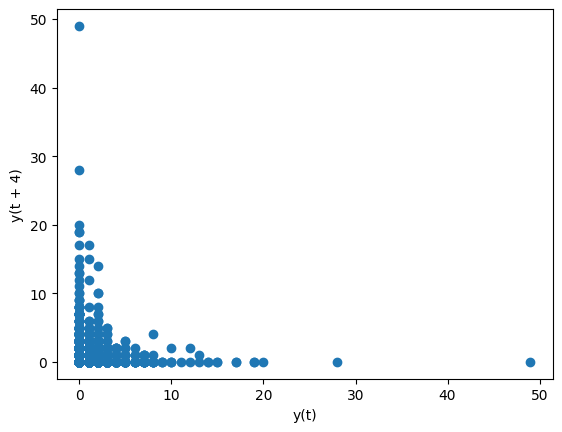

In [28]:
from pandas.plotting import lag_plot

lag_plot(typical_sighting["SIGHTING_COUNT"], lag=4)

#### What if we aggregate by week? - this might smooth the data a bit?

In [ ]:
# Aggregate to Weekly Data
typical_sighting["WEEK_START"] = (
    typical_sighting["DATE"]
    - pd.to_timedelta(typical_sighting["DATE"].dt.dayofweek, unit="d")
).dt.normalize()
typical_sighting["WEEK_START"] = typical_sighting["WEEK_START"].dt.floor(
    "D"
)  # make sure it's date-only, no time

weekly_df = typical_sighting.groupby("WEEK_START")["SIGHTING_COUNT"].sum().reset_index()

In [ ]:
# Make sure you have your WEEK_START column ready (start of week dates)
sightings_data["WEEK_START"] = sightings_data["DATE"] - pd.to_timedelta(
    sightings_data["DATE"].dt.dayofweek, unit="d"
)

# Now sum all sightings by week
total_sightings = (
    sightings_data.groupby("WEEK_START")["SIGHTING_COUNT"]
    .sum()
    .rename("TOTAL_SIGHTINGS")
)
total_sightings = total_sightings.reset_index()

In [ ]:
# Compute ratio: sightings in cell / total sightings that week
weekly_df = pd.merge(weekly_df, total_sightings)

# Fill any NaNs (like weeks with zero total sightings) with 0
weekly_df["SIGHTING_RATIO"] = (
    weekly_df["SIGHTING_COUNT"] / weekly_df["TOTAL_SIGHTINGS"]
).fillna(0)

In [40]:
# fig = px.line(weekly_df, x = 'WEEK_START', y = 'SIGHTING_COUNT')
# fig.show()

In [ ]:
import numpy as np

ratio = weekly_df["SIGHTING_RATIO"].dropna().values
fft = np.fft.fft(ratio - np.mean(ratio))
freqs = np.fft.fftfreq(len(ratio), d=1)
power = np.abs(fft[: len(freqs) // 2]) ** 2
periods = 1 / freqs[: len(freqs) // 2]

periods = np.where(periods == np.inf, 0, periods)

power_df = pd.DataFrame({"power": power, "period": periods})
power_df = power_df.sort_values("period").reset_index(drop=True)

/var/folders/p8/19qwfgfd1b1cn30h8qtz26k00000gn/T/ipykernel_1696/2048865490.py:7: RuntimeWarning:

divide by zero encountered in divide



In [ ]:
fig = px.line(power_df[power_df.period < 365], y="power", x="period")
fig.show()

In [68]:
power_df[power_df.period < 360].sort_values("power", ascending=False).head(10)

,power,period
1205,269.339250,26.100000
1091,186.094482,12.196262
374,171.890077,2.803437
609,157.560519,3.750000
1282,150.853380,113.478261
1163,145.581418,18.380282
4,145.112675,2.006149
605,142.117163,3.728571
581,139.265626,3.604972
1093,134.608238,12.311321


In [ ]:
from statsmodels.tsa.seasonal import STL


def evaluate_stl(y, period):
    stl = STL(y, period=period, robust=True)
    res = stl.fit()

    total_var = np.var(y)
    seasonal_var = np.var(res.seasonal)
    trend_var = np.var(res.trend)
    resid_var = np.var(res.resid)

    return {
        "period": period,
        "seasonal_strength": seasonal_var / total_var,
        "trend_strength": trend_var / total_var,
        "resid_strength": resid_var / total_var,
        "res": res,
    }

In [71]:
y = weekly_df["SIGHTING_RATIO"].dropna()

test_periods = np.unique(
    sorted(
        list(
            power_df[power_df.period < 360]
            .sort_values("power", ascending=False)
            .head(15)
            .period.astype(int)
        )
    )
)
test_periods = list(test_periods) + [27, 28, 29, 30, 53, 54, 56, 57, 58]
results = [evaluate_stl(y, p) for p in test_periods]

for r in results:
    print(f"Period {r['period']}: Seasonal Strength = {r['seasonal_strength']:.2f}")

Period 2: Seasonal Strength = 0.21
Period 3: Seasonal Strength = 0.19
Period 5: Seasonal Strength = 0.08
Period 12: Seasonal Strength = 0.10
Period 18: Seasonal Strength = 0.17
Period 26: Seasonal Strength = 0.26
Period 52: Seasonal Strength = 0.35
Period 113: Seasonal Strength = 0.43
Period 27: Seasonal Strength = 0.12
Period 28: Seasonal Strength = 0.36
Period 29: Seasonal Strength = 0.32
Period 30: Seasonal Strength = 0.30
Period 53: Seasonal Strength = 0.11
Period 54: Seasonal Strength = 0.11
Period 56: Seasonal Strength = 0.39
Period 57: Seasonal Strength = 0.51
Period 58: Seasonal Strength = 0.32


In [ ]:
season_order = ["winter", "spring", "summer", "fall"]
weekly_df["week_month"] = weekly_df["WEEK_START"].dt.month
weekly_df["week_year"] = weekly_df["WEEK_START"].dt.year
weekly_df["week_season"] = weekly_df["week_month"].map(
    {
        12: "winter",
        1: "winter",
        2: "winter",
        3: "spring",
        4: "spring",
        5: "spring",
        6: "summer",
        7: "summer",
        8: "summer",
        9: "fall",
        10: "fall",
        11: "fall",
    }
)
weekly_df["week_of_year"] = weekly_df["WEEK_START"].dt.isocalendar().week
weekly_df = weekly_df.sort_values("WEEK_START").reset_index(drop=True)

In [123]:
# fig = px.box(typical_sighting, x = 'week_season', y = 'SIGHTING_COUNT')
# fig.show()

In [ ]:
fig = px.histogram(weekly_df, x="week_of_year", y="SIGHTING_COUNT")
fig.show()

In [ ]:
import holidays
from datetime import timedelta

us_holidays = holidays.UnitedStates()


def is_holiday(week_start):
    """True if any official U.S. holiday falls in the 7-day window starting from week_start."""
    week_dates = [week_start + timedelta(days=i) for i in range(7)]
    return any(date in us_holidays for date in week_dates)


def is_holiday_with_overlap(week_start):
    """True if week contains a holiday OR Fri/Sat/Sun adjacent to a holiday."""
    week_dates = [week_start + timedelta(days=i) for i in range(7)]

    for d in week_dates:
        if d in us_holidays:
            return True

        # If it's Fri–Sun, check ±1 day for a holiday
        if d.weekday() in [4, 5, 6]:  # Fri/Sat/Sun
            for offset in [-1, 0, 1]:
                neighbor = d + timedelta(days=offset)
                if neighbor in us_holidays:
                    return True
    return False

In [ ]:
weekly_df["is_holiday_week"] = weekly_df["WEEK_START"].apply(is_holiday)
weekly_df["is_holiday_week_with_overlap"] = weekly_df["WEEK_START"].apply(
    is_holiday_with_overlap
)

In [131]:
weekly_df

,WEEK_START,SIGHTING_COUNT,TOTAL_SIGHTINGS,SIGHTING_RATIO,week_month,week_year,week_season,week_of_year,is_holiday_week,is_holiday_week_with_overlap
0,1975-07-28,0.0,1.0,0.000000,7,1975,summer,31,False,False
1,1975-08-04,0.0,1.0,0.000000,8,1975,summer,32,False,False
2,1975-08-11,0.0,0.0,0.000000,8,1975,summer,33,False,False
3,1975-08-18,0.0,3.0,0.000000,8,1975,summer,34,False,False
4,1975-08-25,0.0,0.0,0.000000,8,1975,summer,35,False,True
...,...,...,...,...,...,...,...,...,...,...
2605,2025-06-30,3.0,90.0,0.033333,6,2025,summer,27,True,True
2606,2025-07-07,0.0,79.0,0.000000,7,2025,summer,28,False,False
2607,2025-07-14,0.0,91.0,0.000000,7,2025,summer,29,False,False
2608,2025-07-21,0.0,131.0,0.000000,7,2025,summer,30,False,False


In [138]:
# fig = px.box(weekly_df, x = 'is_holiday_week', y = 'SIGHTING_RATIO', color = 'is_holiday_week')
# fig.show()

### 2. Create Features

Preprocessing
- Aggregate to Weekly Sightings
- Convert Sightings to Ratio of Total Sightings

Features
- Definition Signals
    - H3 Grid - Categorical Encoding
    - Percent Grid Over Water
- Temporal Signals
    - Total Sightings
    - Number of Days with Atleast One Sighting Per Week
    - Add Week of Year
    - Add Season
    - Add Month
    - Add Prior Week of Year
    - Add Prior Season
    - Add Prior Month
    - Week Has Any Sighting Boolean Flag
    - Is Holiday Week < need to define a custom whale-likely observation holidays >
    - Is Holiday Week / Holiday Weekend < need to define a custom whale-likely observation holidays >
    - Is School Break
    - Lagged Sightings Ratio to Capture Near Term Auto-Correlation (Lag 1 - Lag n)
    - Prescence Lagged Sightings Ratio to Capture Near Term Auto-Correlation (Lag 1 - Lag n) < sighting / no sighting in previous observation>
    - Sighting Count Diff Over Lags
    - Add Some Seasonal Lag Components (These seem to be important but need to check less common grids -> Lag Periods: 28, 29, 52, 56, 57, 113) 
    - Rolling Mean
    - Rolling Std
    - Cumulative Sightings Over Last N Weeks (N = 4)
    - Relative Effort Index (weekly sightings relative to long-term weekly median)
- Spatial Signals
    - Neighbor Lagged Sightings
    - Neighbor Prescence Lagged Sightings 


## Build Data
### 1. Open Data

In [139]:
# Parameters
## H3 Grid Resolution for Modeling
h3_resolution = 5

## TMW Data Path
tmw_directory = "/Users/tylerstevenson/Documents/CODE/orcasalmon/data/twm"

## Acartia Data Path
acartia_directory = (
    "/Users/tylerstevenson/Documents/CODE/FindMyWhale/data/raw/sightings"
)

## Marine Area Geometries
marine_geometries_path = "/Users/tylerstevenson/Documents/CODE/FindMyWhale/data/processed/GIS/POLYGONS/SSEA_REGION_5.parquet"

In [ ]:
# Data Ingest
## Open Marine Geometries
marine_area = gpd.read_parquet(marine_geometries_path)
marine_area = marine_area.dissolve()

## Open TMW
tmw_data_cleaned = load_and_process_sighting_data(
    directory=tmw_directory,
    date_col="SIGHTDATE",
    lat_col="LATITUDE",
    lon_col="LONGITUDE",
    id_col="DATE",  # or other proxy for sightings count
    h3_resolution=h3_resolution,
    source="TMW",
)

## Open Acartia
acartia_data_cleaned = load_and_process_sighting_data(
    directory=acartia_directory,
    date_col="CREATED",
    lat_col="LATITUDE",
    lon_col="LONGITUDE",
    id_col="ENTRY_ID",
    h3_resolution=h3_resolution,
    start_date="2022-01-01",
    source="ACARTIA",
)

# Conbine Sightings Data
sightings_data = pd.concat([acartia_data_cleaned, tmw_data_cleaned])

## Clip to Marine Area
sightings_data = clip_sightings_to_geometry(
    sightings_data, h3_resolution=h3_resolution, geometry_gdf=marine_area
)

***

<center>END OF NOTEBOOK</center>

***